In [ ]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("dschettler8845/brats-2021-task1")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'brats-2021-task1' dataset.
Path to dataset files: /kaggle/input/brats-2021-task1


In [ ]:
!pip install nibabel tensorflow matplotlib scikit-learn

In [ ]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

DATA PREPROCESSING

In [ ]:
def load_nifti_file(filepath):
    img = nib.load(filepath)
    return img.get_fdata()

In [ ]:
def normalize_image(image):
    img_min = np.min(image)
    img_max = np.max(image)
    if img_max - img_min == 0:
        return image
    return (image - img_min) / (img_max - img_min)

In [37]:
def preprocess_patient(patient_dir, dataset_path, target_size=(128, 128)):
    path = os.path.join(dataset_path, patient_dir)

    t1 = load_nifti_file(os.path.join(path, f"{patient_dir}_t1.nii.gz"))
    t1ce = load_nifti_file(os.path.join(path, f"{patient_dir}_t1ce.nii.gz"))
    t2 = load_nifti_file(os.path.join(path, f"{patient_dir}_t2.nii.gz"))
    flair = load_nifti_file(os.path.join(path, f"{patient_dir}_flair.nii.gz"))
    mask = load_nifti_file(os.path.join(path, f"{patient_dir}_seg.nii.gz"))

    # Stack modalities
    combined_vol = np.stack([flair, t1, t1ce, t2], axis=-1)

    patient_images = []
    patient_masks = []

    # Iterate through slices
    num_slices = mask.shape[2]
    for i in range(num_slices):
        mask_slice = mask[:, :, i]

        # Skip slices that contain only background (label 0)
        if np.all(mask_slice == 0):
            continue

        # Get corresponding image slice
        img_slice = combined_vol[:, :, i, :]

        # Resize Image (128x128)
        img_slice = tf.image.resize(img_slice, target_size).numpy()
        img_slice = normalize_image(img_slice)

        # Resize Mask (Nearest Neighbor to preserve integer labels)
        mask_slice = tf.image.resize(mask_slice[..., np.newaxis], target_size, method='nearest').numpy()

        mask_onehot = np.zeros((128, 128, 4), dtype=np.float32)
        mask_onehot[:, :, 0] = (mask_slice[:, :, 0] == 0) # Background
        mask_onehot[:, :, 1] = (mask_slice[:, :, 0] == 1) # NCR
        mask_onehot[:, :, 2] = (mask_slice[:, :, 0] == 2) # ED
        mask_onehot[:, :, 3] = (mask_slice[:, :, 0] == 4) # ET

        patient_images.append(img_slice)
        patient_masks.append(mask_onehot)

    return np.array(patient_images), np.array(patient_masks)

U-NET MODEL ARCHITECTURE

In [ ]:
def build_unet(input_shape=(128, 128, 4), num_classes=4):
    inputs = Input(shape=input_shape)

    def conv_block(x, filters, dropout_rate=0.2):
        x = layers.Conv2D(filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization() (x) # Critical for training stability
        x = layers.Activation('relu')(x)

        x = layers.Conv2D(filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization() (x)
        x = layers.Activation('relu')(x)

        if dropout_rate > 0:
            x = layers.Dropout(dropout_rate)(x)
        return x

    # --- Encoder ---
    c1 = conv_block(inputs, 32)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 64)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 128)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # --- Bottleneck ---
    bn = conv_block(p3, 256)

    # --- Decoder ---
    u1 = layers.UpSampling2D((2, 2))(bn)
    u1 = layers.concatenate([u1, c3])
    c4 = conv_block(u1, 128)

    u2 = layers.UpSampling2D((2, 2))(c4)
    u2 = layers.concatenate([u2, c2])
    c5 = conv_block(u2, 64)

    u3 = layers.UpSampling2D((2, 2))(c5)
    u3 = layers.concatenate([u3, c1])
    c6 = conv_block(u3, 32)

    # --- Output ---
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c6)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

METRICS & TRAINING

In [ ]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
def total_loss(y_true, y_pred):
    dice = 1 - dice_coef(y_true, y_pred)
    return dice

In [ ]:
def iou_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

VISUALIZATION

In [ ]:
def plot_results(image, ground_truth, prediction):
    gt_labels = np.argmax(ground_truth, axis=-1)
    pred_labels = np.argmax(prediction, axis=-1)

    pred_labels[pred_labels == 3] = 4
    gt_labels[gt_labels == 3] = 4
    print(f"Ground Truth Labels Present: {np.unique(gt_labels)}")
    print(f"Predicted Labels Present:    {np.unique(pred_labels)}")

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("Input MRI (FLAIR)")
    plt.imshow(image[:, :, 0], cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth (0,1,2,4)")
    plt.imshow(gt_labels, cmap='jet', vmin=0, vmax=4)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask (Mapped)")
    plt.imshow(pred_labels, cmap='jet', vmin=0, vmax=4)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

EXECUTION BLOCK

In [ ]:
data_path = '/kaggle/input/brats-2021-task1'

In [ ]:
import tarfile
import os
file = tarfile.open('/kaggle/input/brats-2021-task1/BraTS2021_Training_Data.tar')

file.extractall('./BraTS2021_Training_Data')

/tmp/ipython-input-2449183184.py:5: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  file.extractall('./BraTS2021_Training_Data')


In [ ]:
TRAIN_DATASET_PATH = './BraTS2021_Training_Data/'

In [ ]:
patient_folders = os.listdir(TRAIN_DATASET_PATH)

all_images = []
all_masks = []

# Processing loop (Limit to first 3-5 patients for testing/RAM constraints)
print("Preprocessing patients...")
for patient_id in patient_folders[:5]:
    if os.path.isdir(os.path.join(TRAIN_DATASET_PATH, patient_id)):
        imgs, msks = preprocess_patient(patient_id, TRAIN_DATASET_PATH)
        if len(imgs) > 0:
            all_images.append(imgs)
            all_masks.append(msks)

# Convert to numpy arrays
X = np.concatenate(all_images)
y = np.concatenate(all_masks)

print(f"Total slices: {X.shape[0]}")
print(f"Image shape: {X.shape}")
print(f"Mask shape: {y.shape}")

Preprocessing patients...
Total slices: 775
Image shape: (775, 128, 128, 4)
Mask shape: (775, 128, 128, 4)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (620, 128, 128, 4)
Shape of X_test: (155, 128, 128, 4)
Shape of y_train: (620, 128, 128, 4)
Shape of y_test: (155, 128, 128, 4)


In [38]:
patient_folders = os.listdir(TRAIN_DATASET_PATH)

all_images = []
all_masks = []

# Processing loop (Limit to first 3-5 patients for testing/RAM constraints)
print("Preprocessing patients...")
for patient_id in patient_folders[:5]:
    if os.path.isdir(os.path.join(TRAIN_DATASET_PATH, patient_id)):
        imgs, msks = preprocess_patient(patient_id, TRAIN_DATASET_PATH)
        if len(imgs) > 0:
            all_images.append(imgs)
            all_masks.append(msks)

# Convert to numpy arrays
X = np.concatenate(all_images)
y = np.concatenate(all_masks)

print(f"Total slices: {X.shape[0]}")
print(f"Image shape: {X.shape}")
print(f"Mask shape: {y.shape}")

Preprocessing patients...
Total slices: 321
Image shape: (321, 128, 128, 4)
Mask shape: (321, 128, 128, 4)


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (256, 128, 128, 4)
Shape of X_test: (65, 128, 128, 4)
Shape of y_train: (256, 128, 128, 4)
Shape of y_test: (65, 128, 128, 4)


In [41]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Saving the best model
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Reducing Learning Rate if it gets stuck
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Stopping early if it stops improving
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint, reduce_lr, early_stopping]
)

Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9855 - dice_coef: 0.9082 - iou_coef: 0.8319 - loss: 0.0918
Epoch 1: val_loss improved from inf to 0.08439, saving model to best_model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step - accuracy: 0.9855 - dice_coef: 0.9083 - iou_coef: 0.8320 - loss: 0.0917 - val_accuracy: 0.9874 - val_dice_coef: 0.9156 - val_iou_coef: 0.8444 - val_loss: 0.0844 - learning_rate: 5.0000e-05
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9861 - dice_coef: 0.9103 - iou_coef: 0.8354 - loss: 0.0897
Epoch 2: val_loss improved from 0.08439 to 0.08206, saving model to best_model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.9861 - dice_coef: 0.9103 - iou_coef: 0.8354 - loss: 0.0897 - val_accuracy: 0.9883 - val_dice_coef: 0.9175 - val_iou_coef: 0.8476 - val_loss: 0.0821 - learning_rate: 5.0000e-05
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9856 - dice_coef: 0.9114 - iou_coef: 0.8372 - loss: 0.0886


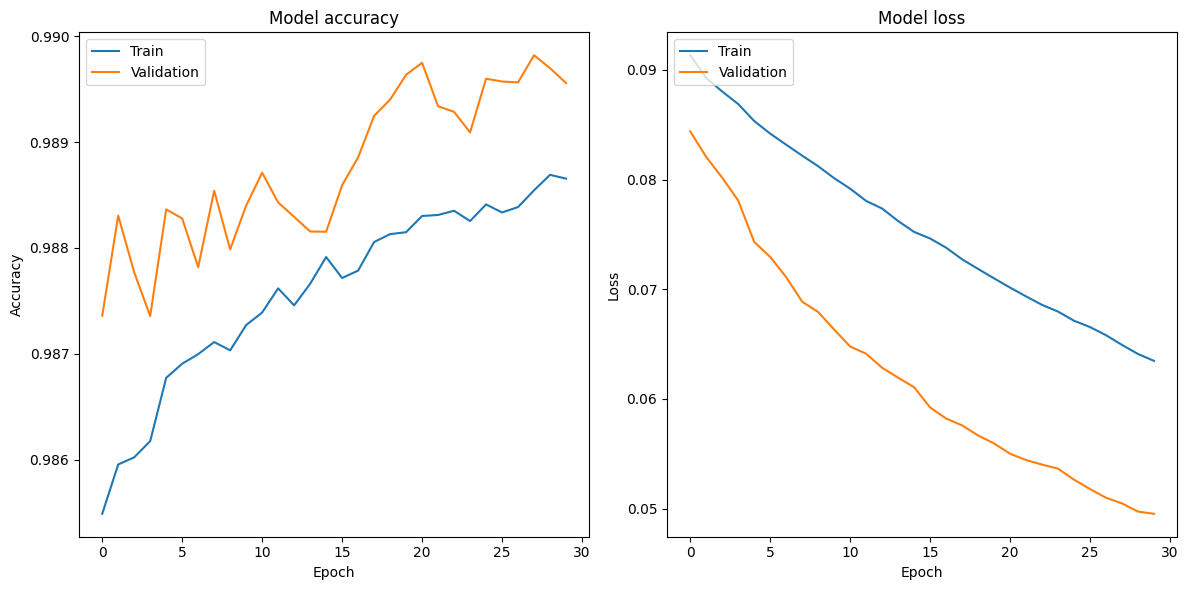

In [44]:
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


Evaluating model on test set...
Test Loss: 0.0495
Test Dice Coefficient: 0.9896
Test IoU Coefficient: 0.9514
Test Accuracy: 0.9073

Visualizing sample predictions...

Sample 1:
Ground Truth Labels Present: [0 1 2 4]
Predicted Labels Present:    [0 1 2]


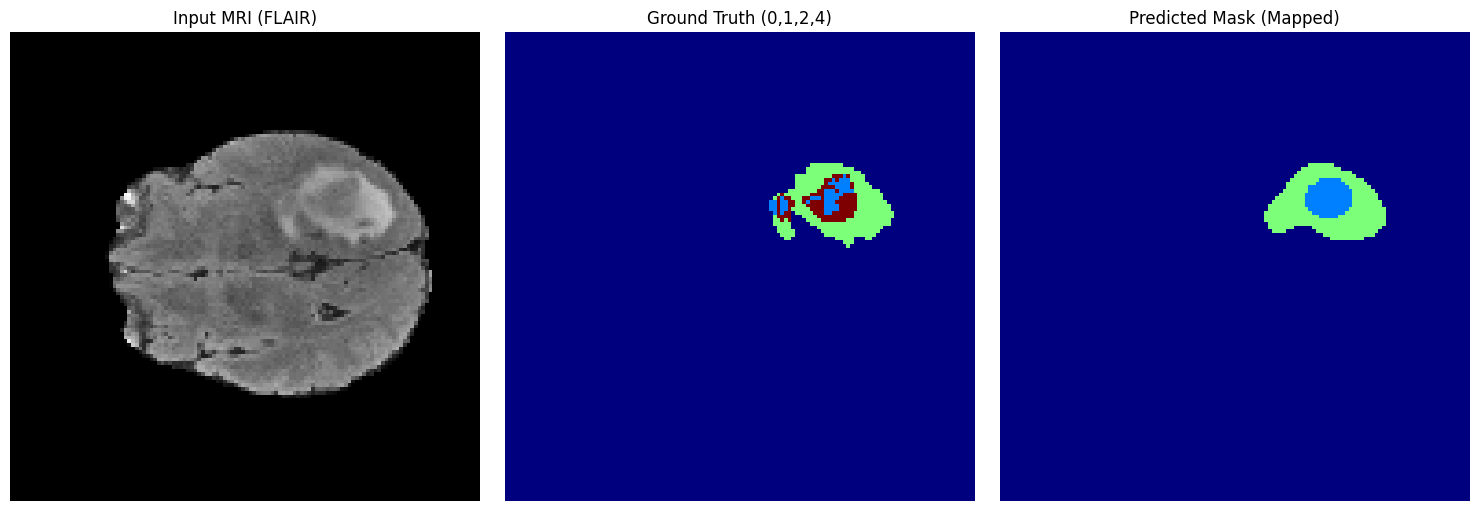


Sample 2:
Ground Truth Labels Present: [0 1 2 4]
Predicted Labels Present:    [0 1 2]


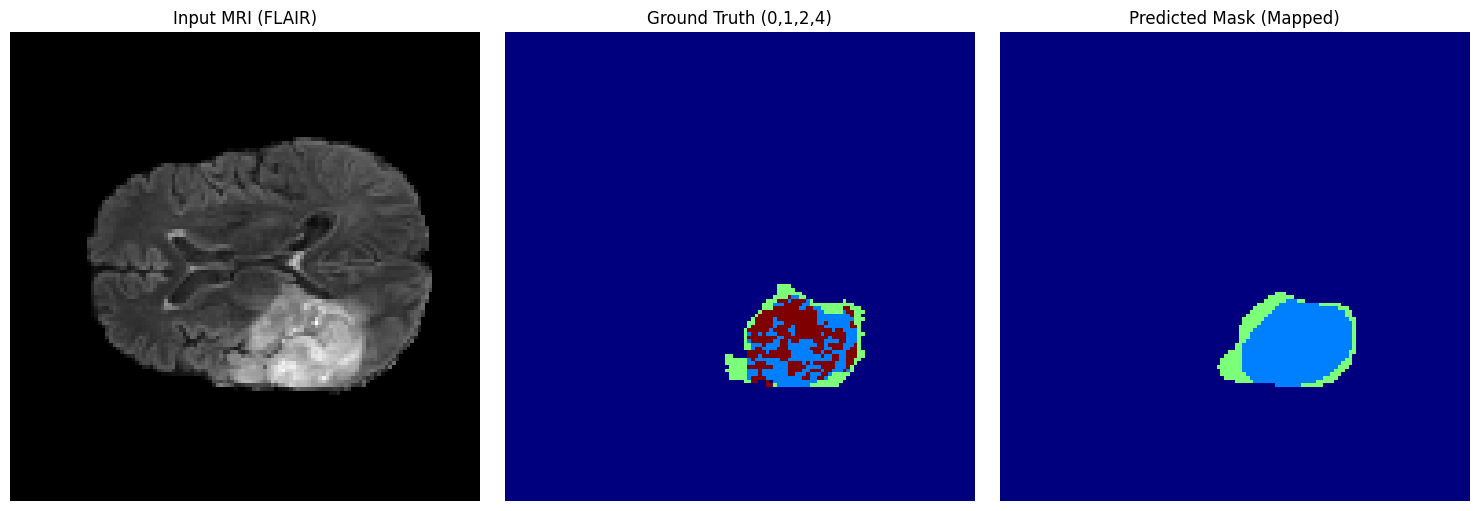


Sample 3:
Ground Truth Labels Present: [0 1 2 4]
Predicted Labels Present:    [0 1 2]


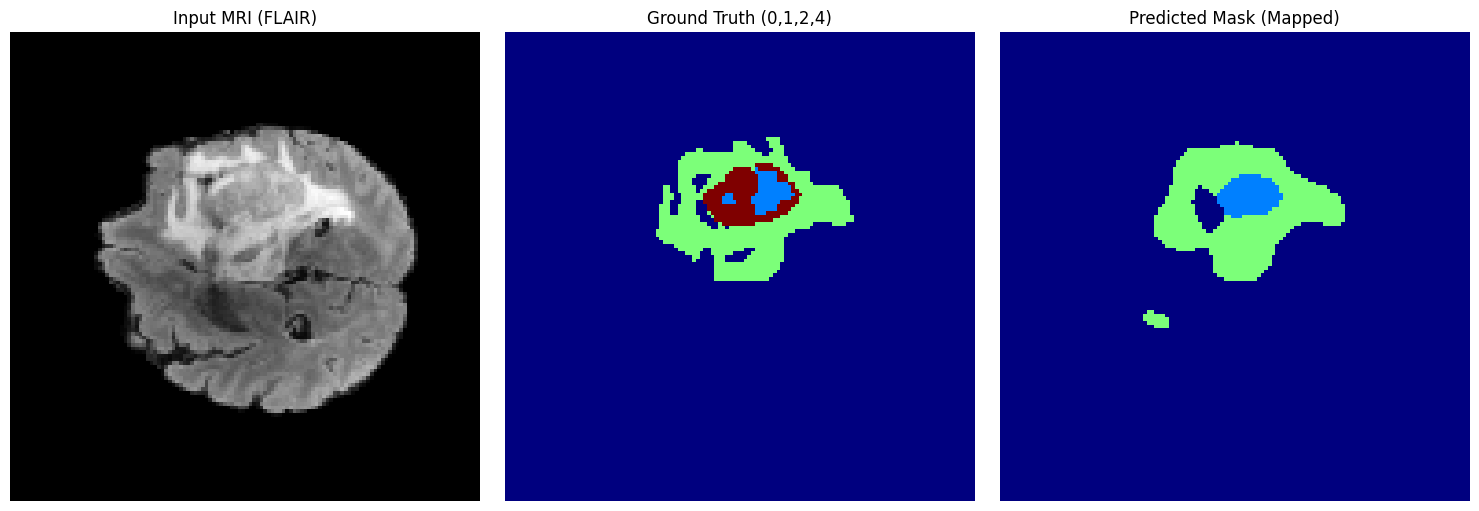


Sample 4:
Ground Truth Labels Present: [0 2]
Predicted Labels Present:    [0]


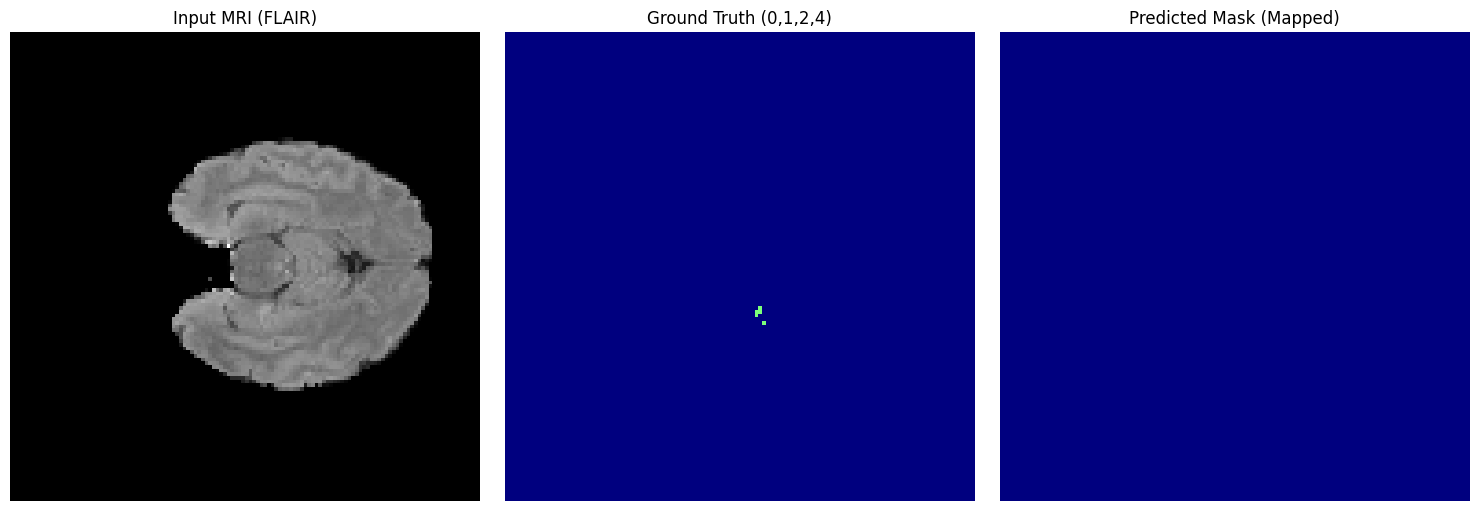


Sample 5:
Ground Truth Labels Present: [0 1 2 4]
Predicted Labels Present:    [0 2]


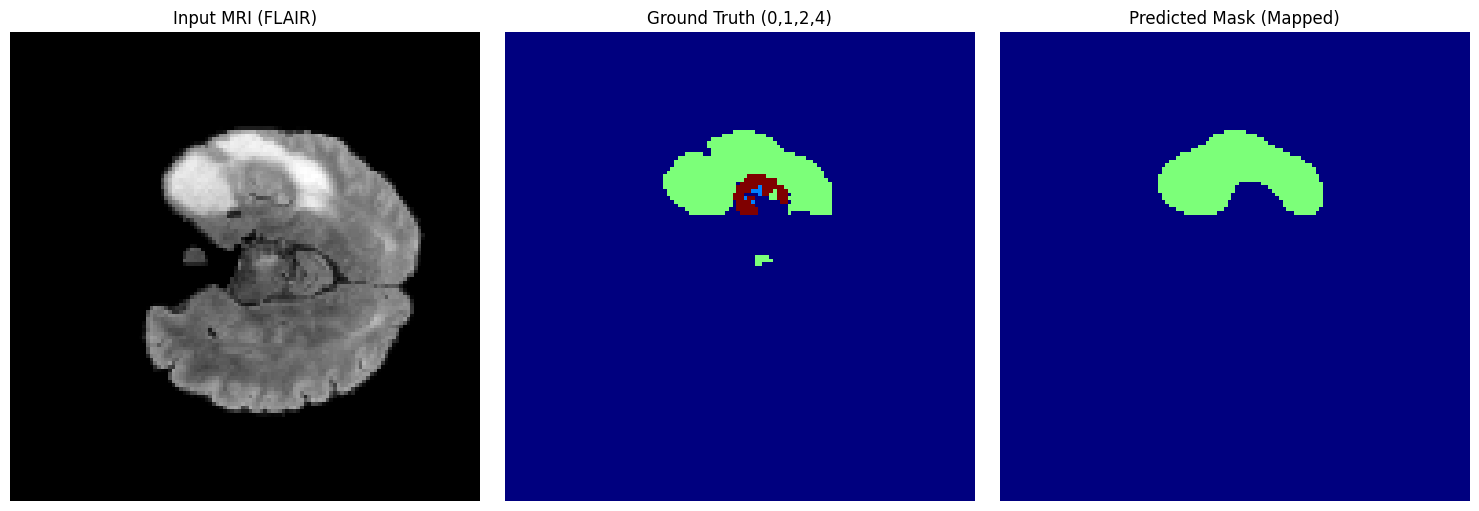

In [45]:
print("\nEvaluating model on test set...")
loss, dice, iou, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Dice Coefficient: {dice:.4f}")
print(f"Test IoU Coefficient: {iou:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


print("\nVisualizing sample predictions...")
# Select a few random samples from the test set
num_samples_to_plot = 5
random_indices = np.random.choice(len(X_test), num_samples_to_plot, replace=False)

for i, idx in enumerate(random_indices):
    sample_image = X_test[idx]
    sample_ground_truth = y_test[idx]
    sample_prediction = model.predict(np.expand_dims(sample_image, axis=0), verbose=0)[0]

    print(f"\nSample {i+1}:")
    plot_results(sample_image, sample_ground_truth, sample_prediction)